In [1]:
import os
import sys
# path_ros = '/opt/ros/lunar/lib/python2.7/dist-packages'
# if path_ros in sys.path : sys.path.remove(path_ros)
    
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL
import scipy.misc

%matplotlib inline

In [2]:
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(ROOT_DIR)

from src.config import Config
import src.utils as utils
import src.model as modellib
import src.visualize as visualize
from src.model import log

import keras
import tensorflow as tf

print ('TF : ', tf.__version__, '  Keras : ', keras.__version__)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_comb', '_fact', '_fact2', '_factk', '_info', '_lsm', '_msg', '_pade', '_source', '_who', 'absolute_import', 'ascent', 'bytescale', 'central_diff_weights', 'comb', 'derivative', 'division', 'doccer', 'face', 'factorial', 'factorial2', 'factorialk', 'fromimage', 'imfilter', 'imread', 'imresize', 'imrotate', 'imsave', 'imshow', 'info', 'logsumexp', 'np', 'pade', 'print_function', 'source', 'test', 'toimage', 'who']
TF :  1.6.0   Keras :  2.1.4


Using TensorFlow backend.


In [3]:
if utils.check_gpu(verbose=0):
    pass
else:
    sys.exit(1)


 =========== nvidia-smi ========== 
Query for existing PIDs using GPU : nvidia-smi --query-compute-apps=pid --format=csv,noheader
 --->  []
TensorFlow Devices: /device:CPU:0
TensorFlow Devices: /device:GPU:0




In [4]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'demo', 'model', "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    

config = ShapesConfig()
# config.display()

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
            # for mapillary I shall traverse the train directory with image/instance sub-dirs.
            # **kwargs = masks = [], bbs = [], 

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [8]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(1500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [9]:
# image_ids = np.random.choice(dataset_train.image_ids, 10)
# for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=5)

In [10]:
# print (config.IMAGE_SHAPE)
# model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# # Which weights to start with?
# init_with = "coco"  # imagenet, coco, or last

# if init_with == "imagenet":
#     model.load_weights(model.get_imagenet_weights(), by_name=True)
# elif init_with == "coco":
#     # Load weights trained on MS COCO, but skip layers that
#     # are different due to the different number of classes
#     # See README for instructions to download the COCO weights
#     model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])
# elif init_with == "last":
#     # Load the last model you trained and continue training
#     model.load_weights(model.find_last()[1], by_name=True)

# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE, 
#             epochs=1, 
#             layers='heads')

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
print (model_path)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/home/play/playment/production/Mask_RCNN/logs/shapes20180307T0729/mask_rcnn_shapes_0001.h5
Loading weights from  /home/play/playment/production/Mask_RCNN/logs/shapes20180307T0729/mask_rcnn_shapes_0001.h5


original_image           shape: (128, 128, 3)         min:   12.00000  max:  252.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000
gt_bbox                  shape: (2, 4)                min:    3.00000  max:  128.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000
 ---> Processing 1 images
 ----> image             shape: (128, 128, 3)         min:   12.00000  max:  252.00000
 ----> molded_images     shape: (1, 128, 128, 3)      min: -111.70000  max:  128.30000
 ----> image_metas       shape: (1, 12)               min:    0.00000  max:  128.00000
 -----> Mask (1, 100, 28, 28, 4)


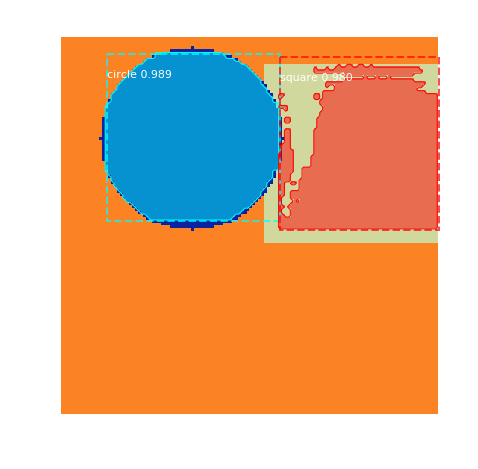

In [20]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

results = model.detect([original_image], verbose=1)

# for i, result in enumerate(results):
#     print ('\nImage ', i+1, ' : ', result['rois'], result['class_ids'])

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))